# Regresión logística

La idea de este notebook es realizar una predicción mediante regresión logística utilizando los preprocessings:
* Standard preprocessing parte 1
* Preprocessing significantes 90% de varianza explicada
* Primeras variables seleccionadas por un árbol de decisión.

In [1]:
# Modelo
from sklearn.linear_model import LogisticRegression

# Preprocessing
from preprocessing import standard_preprocessing_base_parte_1, preprocessing_significantes, standard_preprocessing_mejores_por_arbol
import utils
from sklearn.preprocessing import StandardScaler

# Búsqueda
from sklearn.model_selection import train_test_split, GridSearchCV

# Metrics
from sklearn.metrics import plot_roc_curve, auc, roc_auc_score
from sklearn.metrics import classification_report, plot_confusion_matrix

# Plots
from matplotlib import pyplot as plt
import seaborn as sns

# Otros
import pandas as pd
import numpy as np

In [2]:
df = utils.get_data()

## Modelo 1 - Standard Preprocessing parte 1

Será entrenado con las siguientes variables:

* **Ganancia/Pérdida declara en la bolsa argentina**: `ganancia_perdida_declarada_bolsa_argentina`
* **Edad**: `edad`
* **Rol familiar registrado**: `rol_familiar_registrado`
* **Años estudiados**: `anios_estudiados`

A las que se les aplicará una función de Standarización para que la regresión logísitca y su regularización funcionen correctamente.

In [3]:
X = df[df.columns.drop('tiene_alto_valor_adquisitivo')]
Y = df['tiene_alto_valor_adquisitivo']

X_train_1, X_test_1, y_train_1, y_test_1 = train_test_split(X, Y, random_state=112, stratify=Y)

X_train_1, X_test_1 = standard_preprocessing_base_parte_1(X_train_1, X_test_1)

In [4]:
model = LogisticRegression()
params = [{'penalty': ['l1']        , 'C': np.logspace(-3, 3, 13), 'solver': ['saga'] },
          {'penalty': ['l2']        , 'C': np.logspace(-3, 3, 13), 'solver': ['lbfgs']},
          {'penalty': ['elasticnet'], 'C': np.logspace(-3, 3, 13), 'solver': ['saga'] , 'l1_ratio': np.linspace(0.1, 0.9, 9)}]

gscv1 = GridSearchCV(model, params, scoring='roc_auc', n_jobs=-1, verbose=4, cv=10)

In [5]:
gscv1.fit(X_train_1, y_train_1)

Fitting 10 folds for each of 143 candidates, totalling 1430 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:    4.5s
[Parallel(n_jobs=-1)]: Done 205 tasks      | elapsed:    7.5s
[Parallel(n_jobs=-1)]: Done 376 tasks      | elapsed:   13.1s
[Parallel(n_jobs=-1)]: Done 597 tasks      | elapsed:   20.5s
[Parallel(n_jobs=-1)]: Done 866 tasks      | elapsed:   28.5s
[Parallel(n_jobs=-1)]: Done 1185 tasks      | elapsed:   37.3s
[Parallel(n_jobs=-1)]: Done 1430 out of 1430 | elapsed:   44.0s finished


GridSearchCV(cv=10, estimator=LogisticRegression(), n_jobs=-1,
             param_grid=[{'C': array([1.00000000e-03, 3.16227766e-03, 1.00000000e-02, 3.16227766e-02,
       1.00000000e-01, 3.16227766e-01, 1.00000000e+00, 3.16227766e+00,
       1.00000000e+01, 3.16227766e+01, 1.00000000e+02, 3.16227766e+02,
       1.00000000e+03]),
                          'penalty': ['l1'], 'solver': ['saga']},
                         {'C': array([1.00000000e-03, 3.1622...
                          'penalty': ['l2'], 'solver': ['lbfgs']},
                         {'C': array([1.00000000e-03, 3.16227766e-03, 1.00000000e-02, 3.16227766e-02,
       1.00000000e-01, 3.16227766e-01, 1.00000000e+00, 3.16227766e+00,
       1.00000000e+01, 3.16227766e+01, 1.00000000e+02, 3.16227766e+02,
       1.00000000e+03]),
                          'l1_ratio': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]),
                          'penalty': ['elasticnet'], 'solver': ['saga']}],
             scoring='roc_auc', ver

In [6]:
print("Los parámetros que mejor score obtuvieron para AdaBoost fueron:", gscv1.best_params_)
print("Con un Score (RocAUC) de: ", round(gscv1.best_score_, 4))

Los parámetros que mejor score obtuvieron para AdaBoost fueron: {'C': 0.03162277660168379, 'l1_ratio': 0.1, 'penalty': 'elasticnet', 'solver': 'saga'}
Con un Score (RocAUC) de:  0.8812


Realicemos ahora el modelo por fuera del gridSearch

In [7]:
lr1 = gscv1.best_estimator_

In [8]:
lr1.fit(X_train_1, y_train_1)

LogisticRegression(C=0.03162277660168379, l1_ratio=0.1, penalty='elasticnet',
                   solver='saga')

In [39]:
print(classification_report(y_test_1,lr1.predict(X_test_1), digits=4))

              precision    recall  f1-score   support

           0     0.8600    0.9290    0.8931      6181
           1     0.7001    0.5230    0.5987      1960

    accuracy                         0.8312      8141
   macro avg     0.7801    0.7260    0.7459      8141
weighted avg     0.8215    0.8312    0.8223      8141



Vemos que el modelo tiene un accuracy de 8312%. Un recall común para los ceros, un poco pobre para los unos, esto se verá reflejado en la matriz de confusión

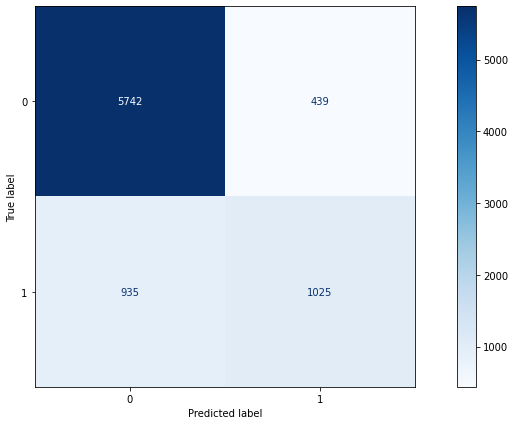

In [10]:
fig, ax = plt.subplots(figsize=(15,7))
plt.grid(False)
plot_confusion_matrix(lr1, X_test_1, y_test_1, cmap=plt.cm.Blues, display_labels=['0', '1'], ax=ax)
plt.show()

Vemos aquí que hay muchos Falsos negativos, es decir que el modelo no está pudiendo predecir correctamente a los unos.

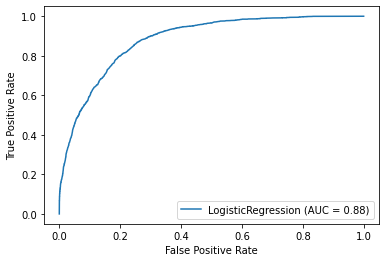

In [11]:
plot_roc_curve(lr1, X_test_1, y_test_1)

In [12]:
roc_auc_score(y_test_1, lr1.predict_proba(X_test_1)[:,1])

0.8813612485926259

Vemos que el RocAUC fue de 0.88, por lo que estamos frente a un modelo decente, pero definitivamente no el mejor.

## Modelo 2 - Preprocessing Significantes 90% varianza explicada

Queremos ver ahora cómo actúa la regresión logística con las variables proyectadas por PCA con 90% de la varianza explicada.


In [13]:
X = df[df.columns.drop('tiene_alto_valor_adquisitivo')]
X = pd.get_dummies(X, drop_first=True)
Y = df['tiene_alto_valor_adquisitivo']

X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(X, Y, random_state=112, stratify=Y)

X_train_2, X_test_2 = preprocessing_significantes(X_train_2, X_test_2, 0.9)

/home/lukas/FIUBA/tp-datos-1c2021-de-angelis-riva-continanza/Parte2/preprocessing.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train['ganancia_perdida_declarada_bolsa_argentina'] = X_train['ganancia_perdida_declarada_bolsa_argentina'].apply(_log_scale)
/home/lukas/FIUBA/tp-datos-1c2021-de-angelis-riva-continanza/Parte2/preprocessing.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test['ganancia_perdida_declarada_bolsa_argentina'] = X_test['ganancia_perdida_declarada_bolsa_argentina'].apply(

In [14]:
model = LogisticRegression()
params = [{'penalty': ['l1']        , 'C': np.logspace(-3, -1, 3), 'solver': ['saga'] },
          {'penalty': ['l2']        , 'C': np.logspace(-3, -1, 3), 'solver': ['lbfgs']},
          {'penalty': ['elasticnet'], 'C': np.logspace(-3, -1, 3), 'solver': ['saga'] , 'l1_ratio': np.linspace(0.1, 0.9, 9)}]

gscv2 = GridSearchCV(model, params, scoring='roc_auc', n_jobs=-1, verbose=4, cv=10)

In [15]:
gscv2.fit(X_train_2, y_train_2)

Fitting 10 folds for each of 33 candidates, totalling 330 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:    9.4s
[Parallel(n_jobs=-1)]: Done 205 tasks      | elapsed:   22.2s
[Parallel(n_jobs=-1)]: Done 330 out of 330 | elapsed:  1.2min finished


GridSearchCV(cv=10, estimator=LogisticRegression(), n_jobs=-1,
             param_grid=[{'C': array([0.001, 0.01 , 0.1  ]), 'penalty': ['l1'],
                          'solver': ['saga']},
                         {'C': array([0.001, 0.01 , 0.1  ]), 'penalty': ['l2'],
                          'solver': ['lbfgs']},
                         {'C': array([0.001, 0.01 , 0.1  ]),
                          'l1_ratio': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]),
                          'penalty': ['elasticnet'], 'solver': ['saga']}],
             scoring='roc_auc', verbose=4)

In [16]:
print("Los parámetros que mejor score obtuvieron para AdaBoost fueron:", gscv2.best_params_)
print("Con un Score (RocAUC) de: ", round(gscv2.best_score_, 4))

Los parámetros que mejor score obtuvieron para AdaBoost fueron: {'C': 0.01, 'l1_ratio': 0.1, 'penalty': 'elasticnet', 'solver': 'saga'}
Con un Score (RocAUC) de:  0.8839


In [17]:
lr2 = gscv2.best_estimator_

In [18]:
lr2.fit(X_train_2, y_train_2)

LogisticRegression(C=0.01, l1_ratio=0.1, penalty='elasticnet', solver='saga')

In [40]:
print(classification_report(y_test_2,lr2.predict(X_test_2), digits=4))

              precision    recall  f1-score   support

           0     0.8676    0.9235    0.8947      6181
           1     0.6972    0.5556    0.6184      1960

    accuracy                         0.8349      8141
   macro avg     0.7824    0.7395    0.7565      8141
weighted avg     0.8266    0.8349    0.8282      8141



Vemos que el modelo obtenido posee métricas similares al anterior modelo.

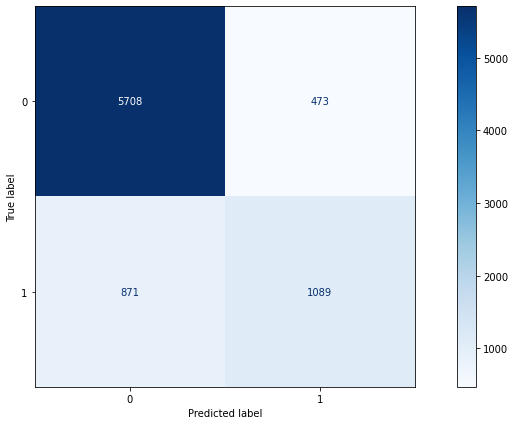

In [20]:
fig, ax = plt.subplots(figsize=(15,7))
plt.grid(False)
plot_confusion_matrix(lr2, X_test_2, y_test_2, cmap=plt.cm.Blues, display_labels=['0', '1'], ax=ax)
plt.show()

La matriz de confusión tamibén es similar a la obtenida por el modelo anterior

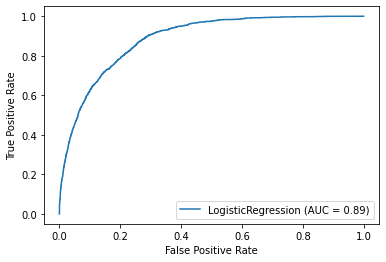

In [21]:
plot_roc_curve(lr2, X_test_2, y_test_2)

In [22]:
roc_auc_score(y_test_2, lr2.predict_proba(X_test_2)[:,1])

0.8850693699256115

La curva ROC y su puntuación AUC son decentes, pero podemos ver que no se trata del mejor modelo.

## Modelo 3 - mejores variables del árbol

In [23]:
X = df[df.columns.drop('tiene_alto_valor_adquisitivo')]
X = pd.get_dummies(X)
Y = df['tiene_alto_valor_adquisitivo']

X_train_3, X_test_3, y_train_3, y_test_3 = train_test_split(X, Y, random_state=27, stratify=Y)

X_train_3, X_test_3 = standard_preprocessing_mejores_por_arbol(X_train_3, X_test_3)

In [24]:
model = LogisticRegression(n_jobs=-1, random_state=27)
params = [{'penalty': ['l1']        , 'C': np.logspace(-3, 3, 13), 'solver': ['saga'] },
          {'penalty': ['l2']        , 'C': np.logspace(-3, 3, 13), 'solver': ['lbfgs']},
          {'penalty': ['elasticnet'], 'C': np.logspace(-3, 3, 13), 'solver': ['saga'] , 'l1_ratio': np.linspace(0.1, 0.9, 9)}]

gscv3 = GridSearchCV(model, params, scoring='roc_auc', n_jobs=-1, cv=10, verbose=4)

In [25]:
gscv3.fit(X_train_3, y_train_3)

Fitting 10 folds for each of 143 candidates, totalling 1430 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:    2.9s
[Parallel(n_jobs=-1)]: Done 205 tasks      | elapsed:    6.0s
[Parallel(n_jobs=-1)]: Done 376 tasks      | elapsed:   11.5s
[Parallel(n_jobs=-1)]: Done 597 tasks      | elapsed:   18.7s
[Parallel(n_jobs=-1)]: Done 866 tasks      | elapsed:   29.9s
[Parallel(n_jobs=-1)]: Done 1185 tasks      | elapsed:   43.4s
[Parallel(n_jobs=-1)]: Done 1430 out of 1430 | elapsed:   52.8s finished


GridSearchCV(cv=10, estimator=LogisticRegression(n_jobs=-1, random_state=27),
             n_jobs=-1,
             param_grid=[{'C': array([1.00000000e-03, 3.16227766e-03, 1.00000000e-02, 3.16227766e-02,
       1.00000000e-01, 3.16227766e-01, 1.00000000e+00, 3.16227766e+00,
       1.00000000e+01, 3.16227766e+01, 1.00000000e+02, 3.16227766e+02,
       1.00000000e+03]),
                          'penalty': ['l1'], 'solver': ['saga']},
                         {'C': arr...
                          'penalty': ['l2'], 'solver': ['lbfgs']},
                         {'C': array([1.00000000e-03, 3.16227766e-03, 1.00000000e-02, 3.16227766e-02,
       1.00000000e-01, 3.16227766e-01, 1.00000000e+00, 3.16227766e+00,
       1.00000000e+01, 3.16227766e+01, 1.00000000e+02, 3.16227766e+02,
       1.00000000e+03]),
                          'l1_ratio': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]),
                          'penalty': ['elasticnet'], 'solver': ['saga']}],
             scoring='

In [26]:
print("Los parámetros que mejor score obtuvieron para AdaBoost fueron:", gscv3.best_params_)
print("Con un Score (RocAUC) de: ", round(gscv3.best_score_, 4))

Los parámetros que mejor score obtuvieron para AdaBoost fueron: {'C': 0.1, 'l1_ratio': 0.2, 'penalty': 'elasticnet', 'solver': 'saga'}
Con un Score (RocAUC) de:  0.8908


In [27]:
lr3 = gscv3.best_estimator_

In [28]:
lr3.fit(X_train_3, y_train_3)

LogisticRegression(C=0.1, l1_ratio=0.2, n_jobs=-1, penalty='elasticnet',
                   random_state=27, solver='saga')

In [41]:
print(classification_report(y_test_3,lr3.predict(X_test_3), digits=4))

              precision    recall  f1-score   support

           0     0.8644    0.9330    0.8974      6181
           1     0.7182    0.5383    0.6153      1960

    accuracy                         0.8380      8141
   macro avg     0.7913    0.7356    0.7564      8141
weighted avg     0.8292    0.8380    0.8295      8141



Nuevamente un modelo un tanto regular, con un accuracy de 83.80. Veamos ahora la matriz de confusión.

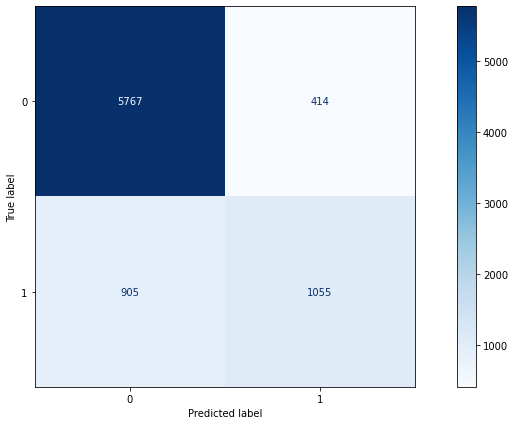

In [42]:
fig, ax = plt.subplots(figsize=(15,7))
plt.grid(False)
plot_confusion_matrix(lr3, X_test_3, y_test_3, cmap=plt.cm.Blues, display_labels=['0', '1'], ax=ax)
plt.show()

Vemos que la matriz de confusión sufre los mismos problemas que las anteriores, hay muchos falsos negativos y esto se debe al poco recall de unos para los modelos de regresión logística.

Veamos la curva Roc y su valor de RocAUC

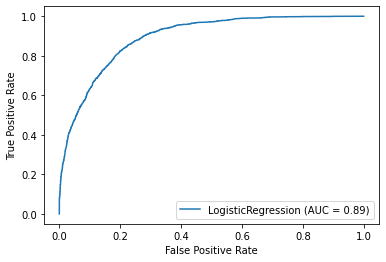

In [31]:
plot_roc_curve(lr3, X_test_3, y_test_3)

In [32]:
roc_auc_score(y_test_3, lr3.predict_proba(X_test_3)[:,1])

0.892645293839911

Vemos que obtuvo un valor de 0.893. Siendo este el mejor de todos los modelos de regresión logística, pero mucho peor que otros modelos diferentes.

### Persistencia

In [33]:
import pickle

In [34]:
pickle.dump(lr1, open("Modelos/LogisticRegression/lr1.pickle", "wb"))
pickle.dump(lr2, open("Modelos/LogisticRegression/lr2.pickle", "wb"))
pickle.dump(lr3, open("Modelos/LogisticRegression/lr3.pickle", "wb"))

# Predicción de HoldOut

Usaremos para predecir la regresión logísitca obtenida para el preprocessing standard mejores variables según árbol.

In [35]:
lr3 = pickle.load(open("Modelos/LogisticRegression/lr3.pickle", "rb"))

In [36]:
def holdout():
    dfv = utils.get_data()
    Xv = dfv[dfv.columns.drop('tiene_alto_valor_adquisitivo')]
    Xv = pd.get_dummies(Xv)

    ids, X = utils.get_holdout_data()
    X = pd.get_dummies(X)

    notInHoldout=[]
    for c in Xv.columns:
        if c not in X.columns:
            notInHoldout.append(c)
    X[notInHoldout] = 0

    Xv, X = standard_preprocessing_mejores_por_arbol(Xv, X)
    return ids, X

In [37]:
ids, X = holdout()

In [38]:
utils.escribir_holdout(lr3.predict(X), "6 - LogisticRegression", ids)